In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tflite_support import metadata as _metadata

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers

## Prepare training and validation datasets

In [2]:
epochs=50
batch_size = 80
img_height = 180
img_width = 180
image_shape = (img_height, img_width, 3)

directory = "IMAGES"

log_root = "logs"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=123
)

steps_per_epoch = len(train_ds)
num_classes = len(train_ds.class_names)

Found 900 files belonging to 6 classes.
Using 720 files for training.
Found 900 files belonging to 6 classes.
Using 180 files for validation.


In [3]:
class_names = train_ds.class_names

print("Class names: " + str(class_names))
with open("labelmap.txt", "w") as f:
    for c in class_names:
        f.write(c)
        f.write('\n')

Class names: ['1', '10', '2', '20', '5', '50']


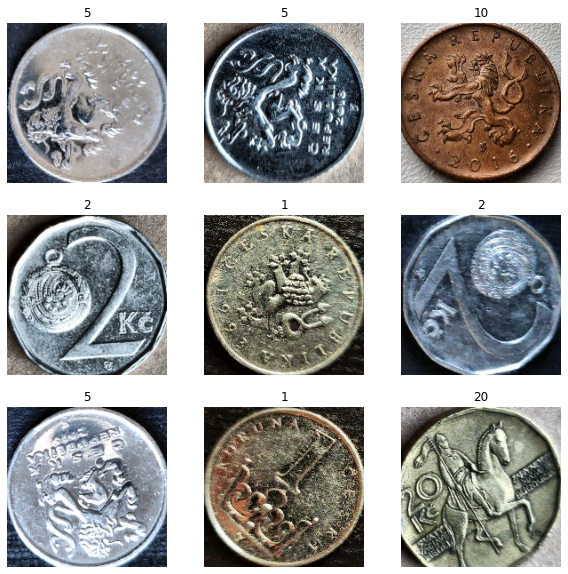

In [4]:
images, labels = next(iter(train_ds.skip(3).take(1)))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Optimize the dataset for performance

`Dataset.cache()` - to keep the images in memory after they're loaded off disk during the first epoch

`Dataset.prefetch()` - overlaps data preprocessing and model execution while training

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Callbacks

In [164]:
# avoid overlearning
class stop_learning_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

def learning_rate_schedule(epoch):
    if epoch < epochs//2:
        return 1e-3
    
    if epoch < 2*epochs//3:
        return 1e-4
    
    return 1e-5
    
# adjust learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)

# data preprocessing
preprocessing_layer = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape), # [0, 255] -> [0, 1]
])

def get_callbacks(model):
    # TensorBoard callback
    timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    logdir = os.path.join(log_root, f'{model.name}_{timestamp}')
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    return [lr_schedule, tensorboard_callback, stop_learning_callback()]

## Train model

In [7]:
def train_model(model, 
                batch_size=batch_size, 
                n_epochs=epochs,  
                optimizer=keras.optimizers.Adam, 
                learning_rate=0.001):
    
    opt = optimizer(lr=learning_rate)
    model.compile(optimizer=opt, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=n_epochs,
        verbose=1,
        callbacks=get_callbacks(model)
    )
    
data_augmentation_layer = keras.Sequential(
    [
        # randomly rotate in the interval [-0.1*2pi, 0.1*2pi]
        layers.experimental.preprocessing.RandomRotation(0.1, input_shape=image_shape),
    ]
)

## MLP

In [ ]:
model_MLP = Sequential([
    preprocessing_layer,
    layers.Flatten(input_shape=image_shape),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')],
    name = 'MLP'
)

#model_MLP.summary()

train_model(model_MLP)

## 1-layered CNN

In [9]:
cnn = Sequential([
    preprocessing_layer,
    data_augmentation_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=image_shape),
    layers.MaxPooling2D(pool_size=2, strides=2),
    #layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')],
    name = 'CNN_1_no_dropout'
)

#cnn.summary()

train_model(cnn)

Epoch 1/20
1/9 [==>...........................] - ETA: 0s - loss: 1.7911 - accuracy: 0.1000WARNING:tensorflow:From /home/atti/bin/miniconda3/envs/PV162/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 5s 531ms/step - loss: 13.7979 - accuracy: 0.1861 - val_loss: 8.1871 - val_accuracy: 0.2278
Epoch 2/20
9/9 [==============================] - 5s 509ms/step - loss: 4.1244 - accuracy: 0.3125 - val_loss: 2.3378 - val_accuracy: 0.3500
Epoch 3/20
9/9 [==============================] - 7s 786ms/step - loss: 2.0363 - accuracy: 0.4514 - val_loss: 1.9094 - val_accuracy: 0.4444
Epoch 4/20
9/9 [==============================] - 6s 709ms/step - loss: 1.2182 - accuracy: 0.4458 - val_loss: 1.1350 - val_accuracy: 0.6167
Epoch 5/20
9/9 [==============================] - 7s 77

## 2-layered CNN

In [53]:
cnn = Sequential([
    preprocessing_layer,
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=image_shape,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=image_shape,
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')],
    name = 'CNN_2_aug_dropout_l2_V2'
)

#cnn.summary()

train_model(cnn)

Epoch 1/20
9/9 [==============================] - 5s 561ms/step - loss: 1.6653 - accuracy: 0.3111 - val_loss: 86.6364 - val_accuracy: 0.4111
Epoch 2/20
9/9 [==============================] - 6s 670ms/step - loss: 1.2773 - accuracy: 0.4667 - val_loss: 89.4937 - val_accuracy: 0.5000
Epoch 3/20
9/9 [==============================] - 7s 781ms/step - loss: 1.0899 - accuracy: 0.6056 - val_loss: 93.8281 - val_accuracy: 0.4889
Epoch 4/20
9/9 [==============================] - 7s 828ms/step - loss: 0.8922 - accuracy: 0.6583 - val_loss: 159.7584 - val_accuracy: 0.4611
Epoch 5/20
9/9 [==============================] - 8s 835ms/step - loss: 0.6702 - accuracy: 0.7750 - val_loss: 131.2971 - val_accuracy: 0.6000
Epoch 6/20
9/9 [==============================] - 8s 913ms/step - loss: 0.6042 - accuracy: 0.7722 - val_loss: 249.2549 - val_accuracy: 0.5056
Epoch 7/20
9/9 [==============================] - 7s 809ms/step - loss: 0.5148 - accuracy: 0.8181 - val_loss: 183.6003 - val_accuracy: 0.6167
Epoch 8/2

## 3-layered CNN

In [8]:
cnn = Sequential([
    preprocessing_layer,
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=image_shape),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')],
    name = 'CNN_3_gradual_dropout0.2'
)

#cnn.summary()

train_model(cnn)

Epoch 1/20
1/9 [==>...........................] - ETA: 0s - loss: 1.8152 - accuracy: 0.1125WARNING:tensorflow:From /home/atti/bin/miniconda3/envs/PV162/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
9/9 [==============================] - 7s 741ms/step - loss: 1.7328 - accuracy: 0.2403 - val_loss: 1.5457 - val_accuracy: 0.3278
Epoch 2/20
9/9 [==============================] - 10s 1s/step - loss: 1.3609 - accuracy: 0.4556 - val_loss: 1.2722 - val_accuracy: 0.3778
Epoch 3/20
9/9 [==============================] - 12s 1s/step - loss: 1.1562 - accuracy: 0.4792 - val_loss: 1.1652 - val_accuracy: 0.4889
Epoch 4/20
9/9 [==============================] - 10s 1s/step - loss: 0.9273 - accuracy: 0.6542 - val_loss: 1.1292 - val_accuracy: 0.5833
Epoch 5/20
9/9 [==============================] - 12s 1s/step 

## 4-layered CNN

In [167]:
cnn = Sequential([
    preprocessing_layer,
    data_augmentation_layer,
    layers.Conv2D(16, 3, padding='same', input_shape=image_shape),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(32, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(64, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(128, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')],
    name = 'CNN_4_gradual_dropout0.5_nodense'
)

cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
cnn.summary()

#train_model(cnn)

Model: "CNN_4_gradual_dropout0.5_nodense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
activation_72 (Activation)   (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_73 (Activation)   (None

## CNN with global pooling

## Predict on new data

Predicted: 10 with a 18.69% confidence.
Correct: 50


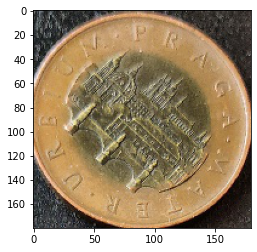

In [171]:
import random

class_num = 5
model = cnn

# get image path
img_dir_path = directory + "/" + str(class_names[class_num])
img_dir = [f for f in os.listdir(img_dir_path) if os.path.isfile(img_dir_path + "/" + f)]
img_name = img_dir[random.randint(0, len(img_dir)-1)]
img_path = img_dir_path + "/" + img_name

# load image
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array_batch = tf.expand_dims(img_array, 0) # Create a batch

# predict
predictions = model.predict(img_array_batch)

#print(predictions)

# show results
plt.imshow(img_array/255)

print(
    "Predicted: {} with a {:.2f}% confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print("Correct: " + str(class_names[class_num]))

## Export to .tflite

In [154]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwpynv8g5/assets


INFO:tensorflow:Assets written to: /tmp/tmpwpynv8g5/assets
